# Image Analysis for 2D Gaussian
### - Güner Aygin

This code takes a raw image of what is expected to be a Gaussian distribution, and using an optimisation function returns the optimal parameters which describe the image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import cv2 # required to read image

### Two-dimensional Gaussian Function

#### Circular Gaussian Function

The equation for a two-dimensional Gaussian function is given by

$$ f(x,y) = A \exp \left(- \left(\frac{(x-x_0)^2}{2 \sigma_x^2} + \frac{(y-y_0)^2}{2 \sigma_y^2} \right) \right), $$

where $A$ is the amplitude, $x_0$, $y_0$ is the centre, $\sigma_x$, $\sigma_y$ are the $x$ and $y$ spreads of the 'spot'.

The code used for the Circular Gaussian function (which we won't be using as it's not general enough) is shown below, with an example.

In [2]:
def gaussian(height, x0, y0, sigma_x, sigma_y):
    """Returns a gaussian function with the given parameters"""
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)
    return lambda x,y: height*np.exp(
                -(((x-x0)/(1*sigma_x))**2+((y-y0)/(1*sigma_y))**2)/2) # idk if it should be 2*sigma

def twoD_Gaussian(height, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    sigma_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    sigma_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, sigma_x, sigma_y

def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

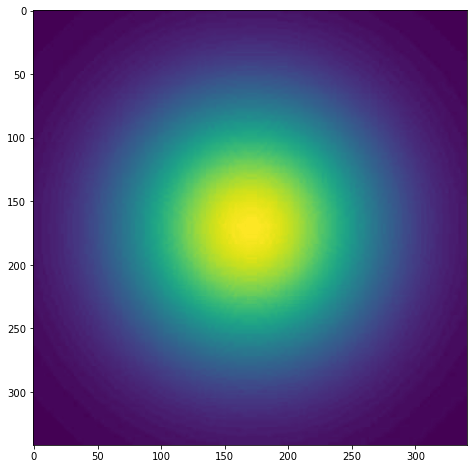

[256.48478001 170.50681501 170.00114158  71.60936108  71.39279562]


In [3]:
import scipy.optimize as optimize

''' Use this to create your own Gaussian Data '''
# Create the gaussian data
Xin, Yin = np.mgrid[0:201, 0:201]
data = gaussian(3, 100, 100, 20, 40)(Xin, Yin) + np.random.random(Xin.shape)

''' Actual Data from test image '''
img = cv2.imread('gaus2d.jpg',0)
fig = plt.figure(figsize=(8,8))
plt.imshow(img)

params = fitgaussian(img)
fit = gaussian(*params)

#plt.contour(fit(*np.indices(img.shape)))
ax = plt.gca()
(height, x0, y0, sigma_x, sigma_y) = params 
#plt.savefig('circular_gauss.jpg')
plt.show()

print(params)

#### Elliptical Gaussian Function

In general, a two-dimensional elliptical Gaussian function is expressed as 

$$ f(x,y) = A \exp \left(- \left(a(x-x_0)^2 + 2b(x-x_0)(y-y_0) + c(y-y_0)^2 \right) \right),$$ 

where $$a = \frac{\cos^2 \theta}{2 \sigma_x^2} + \frac{\sin^2 \theta}{2 \sigma_y^2} $$

$$b = \frac{\sin 2\theta}{4 \sigma_x^2} + \frac{\sin 2\theta}{4 \sigma_y^2} $$

$$c = \frac{\sin^2 \theta}{2 \sigma_x^2} + \frac{\cos^2 \theta}{2 \sigma_y^2} $$

The code used to optimize the elliptical Gaussian function can still be used for circular functions, and so it should be the one used for the final image analysis.

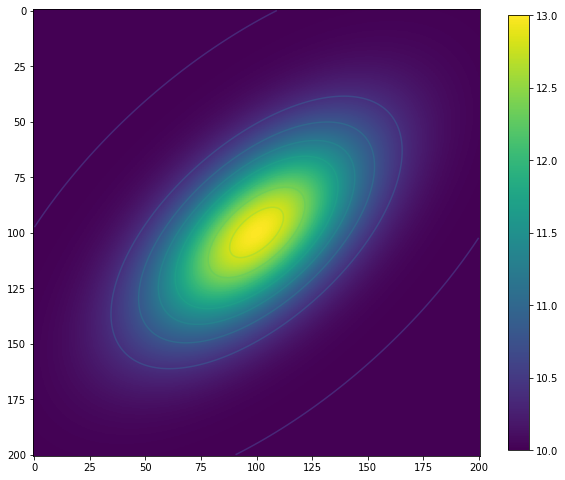

[  3.00216415 100.02367166  99.91757315  19.96828611  40.05501461
  40.0002163    9.99840124]


In [4]:
''' 
    This is an example using a madeup elliptical Gaussian function to show 
    how accurately it can optimise it 
'''

def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x,y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)
    sigma_x = float(sigma_x)
    sigma_y = float(sigma_y)
    theta = float(theta)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    return (offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))).flatten()

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 40, 10)

initial_guess = (10,100,100,20,40,40,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

# Fitting the data
popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)

data_fitted = twoD_Gaussian((x, y), *popt)

(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt

# plot twoD_Gaussian data generated above and the contour fit
fig = plt.figure(figsize=(10,10))
plt.imshow(data.reshape(201, 201))
plt.colorbar(shrink=0.8)
plt.contour(data_fitted.reshape(201,201))

plt.savefig('ellip_gauss.jpg')
plt.show()

print(popt)

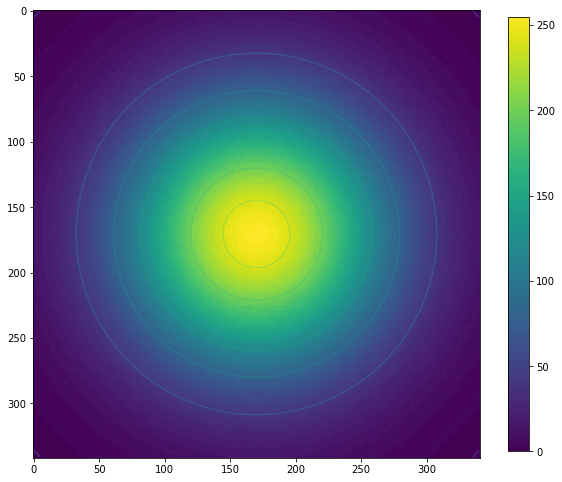

[ 2.56880520e+02  1.69501221e+02  1.70006826e+02  7.16830489e+01
  7.19014583e+01  2.53024225e+04 -1.12554217e+00]


In [5]:
''' This uses the same image as was used in the circular Gaussian code '''

# Create x and y indices
x = np.linspace(0, 339, 341)
y = np.linspace(0, 340, 342)
x, y = np.meshgrid(x, y)

initial_guess = (250,170,170,72,72,3,1)
# Amplitude, x0, y0, sigma_x, sigma_y, theta, offset

# Fitting the data
popt, pcov = opt.curve_fit(twoD_Gaussian, (x,y), img.flatten(), p0=initial_guess) 
# image data needs to be flattened for code to work

data_fitted = twoD_Gaussian((x, y), *popt)

(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt

# plot twoD_Gaussian data generated above and the contour fit
fig = plt.figure(figsize=(10,10))
plt.imshow(img.reshape(342, 341))
plt.colorbar(shrink=0.8)
plt.contour(data_fitted.reshape(342,341))

plt.savefig('circular gauss 2.jpg')
plt.show()

print(popt)

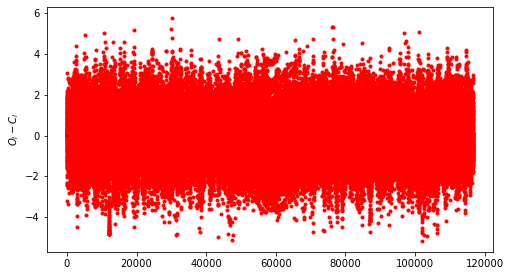

In [6]:
# Residuals for 2D Gaussian in just 1d.

best_fit = twoD_Gaussian((x, y), popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])
residuals = img.flatten() - best_fit
fig = plt.figure(figsize=(8,4.5))
plt.scatter(np.linspace(0,116622,116622),residuals, color='red',marker='.')
plt.plot(np.linspace(0,200,200), np.zeros(200), 'k--')
plt.ylabel('$O_i - C_i$', size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [18]:
(1 - params[0]/popt[0])*100
(1 - params[4]/popt[4])*100

0.707444236837107

## 3D Plotting of Fitted Gaussian

https://likegeeks.com/3d-plotting-in-python/

In [ ]:
popt[†

rv = multivariate_normal([, Y_mean],[[X_var, 0], [0, Y_var]])

# Image Analysis for 1D Gaussian

The 2D Gaussian optimization should be a lot more difficult than a 1D Gaussian optimizer. For completeness I will create a fitting plot for 1D.

### Plotting 1D Gaussian

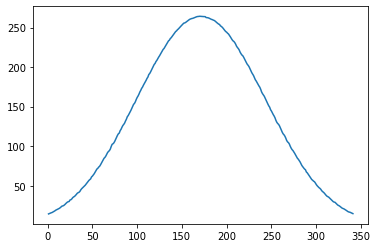

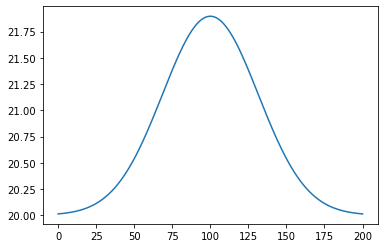

In [6]:
#### Plotting for an image ####
column_average = np.array([np.sum(img[:,n])/len(img[:,n]) for n in range(341)])
row_average = np.array([np.sum(img[n,:])/len(img[n,:]) for n in range(341)])
data_average1 = column_average + row_average # value of this does not affect sigma 
      
x_values1 = np.arange(1,342)    

plt.plot(x_values1, data_average1)
plt.show()

#### Plotting for the created data ####
data = data.reshape(201,201)
column_average = np.array([np.sum(data[:,n])/len(data[:,n]) for n in range(201)])
row_average = np.array([np.sum(data[n,:])/len(data[n,:]) for n in range(201)])
data_average2 = column_average + row_average
      
x_values2 = np.arange(201)    

plt.plot(x_values2, data_average2)
plt.show()

### 1D Gaussian Function

In 1D the Gaussian function has the form:

$$ g(x) = \frac{A}{\sigma \sqrt{2 \pi}} e^{-\left(\frac{(x-\mu)^2}{2 \sigma^2}\right)}, $$

where A is the amplitude, $\mu$ is the mean, and $\sigma$ is the standard deviation in $x$. 

72.11075541326372


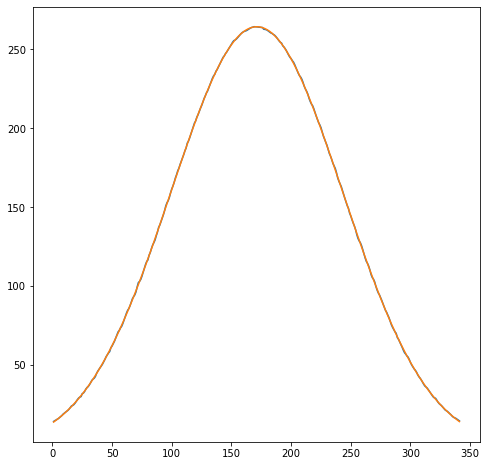

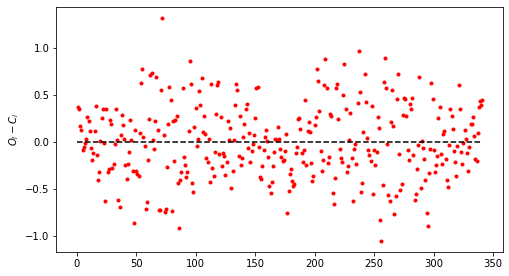

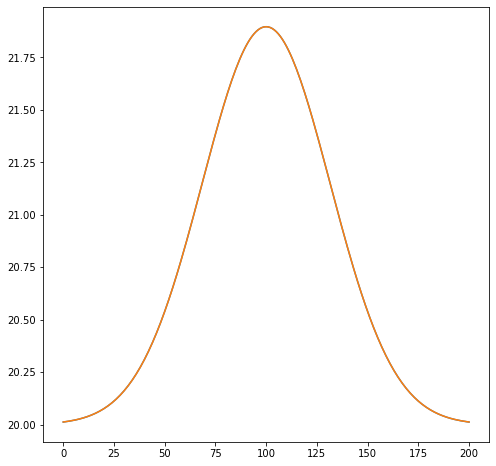

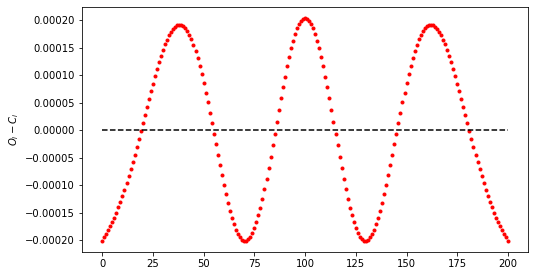

In [7]:
def oneD_gauss(x, mu, sigma, A, c):
    return  c + A*np.exp(-((x-mu)**2)/(2*sigma**2)) * 1/(sigma * np.sqrt(2*np.pi))

initial_guess = (170, 70, 250, 0)
popt, pcov = opt.curve_fit(oneD_gauss, x_values1, data_average1, p0=initial_guess)

fig = plt.figure(figsize=(8,8))

print(popt[1])
plt.plot(x_values1, data_average1)
plt.plot(x_values1, oneD_gauss(x_values1, popt[0], popt[1], popt[2], popt[3]))
plt.show()

best_fit = oneD_gauss(x_values1, popt[0], popt[1], popt[2], popt[3])
residuals = data_average1 - best_fit
fig = plt.figure(figsize=(8,4.5))
plt.scatter(x_values1,residuals, color='red',marker='.')
plt.plot(np.linspace(0,341,341), np.zeros(341), 'k--')
plt.ylabel('$O_i - C_i$', size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

fig = plt.figure(figsize=(8,8))

initial_guess = (100, 30, 22, 20)
popt2, pcov2 = opt.curve_fit(oneD_gauss, x_values2, data_average2, p0=initial_guess)

plt.plot(x_values2, data_average2)
plt.plot(x_values2, oneD_gauss(x_values2, popt2[0], popt2[1], popt2[2], popt2[3]))
plt.show()

best_fit2 = oneD_gauss(x_values2, popt2[0], popt2[1], popt2[2], popt2[3])
residuals = data_average2 - best_fit2
fig = plt.figure(figsize=(8,4.5))
plt.scatter(x_values2,residuals, color='red',marker='.')
plt.plot(np.linspace(0,200,200), np.zeros(200), 'k--')
plt.ylabel('$O_i - C_i$', size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

Note that the shape of the final residuals is due to the resolution used when calculating the function. As you can see, the residual values are very small. This is because the data we are fitting is a perfect Gaussian which we have coded above.

When we compare the value of $\mu$ and the values of $x_0$ and $y_0$ for the second graph, we see that they are very similar. For $\sigma$, we see that the value obtained is very close to the average of $\sigma_x$ and $\sigma_y$ from the 2D Gaussian.

# Time of Flight Measurement of Cold Atoms

https://iopscience.iop.org/article/10.1088/1464-4266/4/1/310/pdf

We can measure the temperature of the cold atoms using a method known as 'time of flight' measurement (TOF).

The velocity of the trapped atoms is described by the Maxwell-Boltzmann distribution:

$$ f(v) = \frac{1}{v \sqrt{2 \pi}} \exp{\left(-\frac{m v_x^2}{2 v_{rms}}\right)} $$

$$ v = \sqrt{\frac{k_B T}{M}} $$

where $v$ is the square root of the average square velocity.

The Gaussian standard distribution $\sigma$, which is asociated with the velocity distribution of the atom cloud, is related to the temperature $T$ of the atoms.



# Camera Test

Our camera outputs an image of size 1280 x 960 pixels, with each pixel having a size of 3$\mu$m by $3\mu$m. However the saved images have an array shape of (960, 1280, 3). The final value of 3 refers to each of the RGB values of the image. 

These RGB values are unnecessary for plotting the intensity distribution of the gas cloud. Using the package 'skimage' we can convert the RGB image to greyscale, so that we obtain a two-dimensional array which we can then use to fit to the Gaussian.

In [8]:
test = cv2.imread('camtest1.jpg')
np.shape(test)

(960, 1280, 3)

In [9]:
from skimage import data
from skimage.color import rgb2gray

test_grey = rgb2gray(test)
np.shape(test_grey)

(960, 1280)

### Plotting the test image

In [31]:
x = np.linspace(0, 1279, 1280)*3e-6
y = np.linspace(0, 959, 960)*3e-6
x, y = np.meshgrid(x, y)

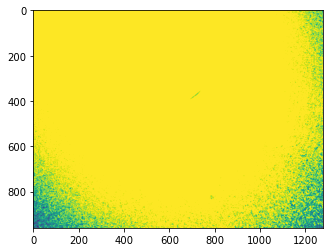

In [40]:
plt.imshow(test_grey)
plt.show()

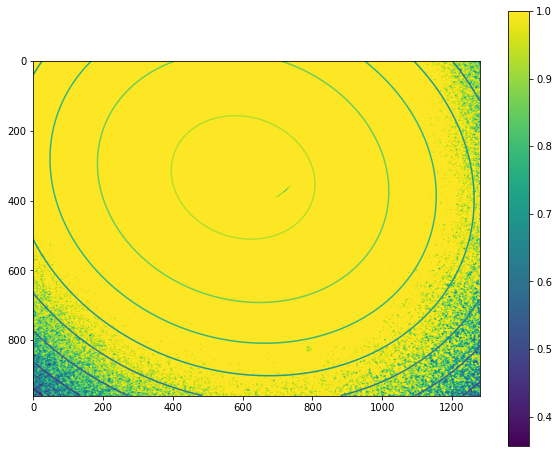

[ 7.26273825e+03  6.01066663e+02  3.33392940e+02  1.40656697e+05
  1.16343683e+05  2.82633323e+00 -7.26170521e+03]


In [41]:
x = np.linspace(0, 1279, 1280)
y = np.linspace(0, 959, 960)
x, y = np.meshgrid(x, y)

initial_guess = (1,650,400,700,700,3,1)
# Amplitude, x0, y0, sigma_x, sigma_y, theta, offset

popt, pcov = opt.curve_fit(twoD_Gaussian, (x,y), test_grey.flatten(), p0=initial_guess) 
# image data needs to be flattened for code to work

data_fitted = twoD_Gaussian((x, y), *popt)

(amplitude, x0, y0, sigma_x, sigma_y, theta, offset) = popt

# plot twoD_Gaussian data generated above and the contour fit
fig = plt.figure(figsize=(10,10))
plt.imshow(test_grey.reshape(960, 1280))
plt.colorbar(shrink=0.8)
plt.contour(data_fitted.reshape(960,1280))
plt.show()

print(popt)

Our value for $\sigma$ is given in terms of pixels. In order to map that onto the actual size of the atoms, we multiply by $3 \times 10^{-6}$

In [42]:
popt*3e-6

array([ 2.17882147e-02,  1.80319999e-03,  1.00017882e-03,  4.21970090e-01,
        3.49031049e-01,  8.47899970e-06, -2.17851156e-02])